In [1]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pylab as plt
import numpy as np

In [28]:
def plot_channels(W):
    n_out = W.shape[0]
    n_in = W.shape[1]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(n_out, n_in)
    fig.subplots_adjust(hspace=0.1)
    out_index = 0
    in_index = 0
    
    #plot outputs as rows inputs as columns 
    for ax in axes.flat:
        if in_index > n_in-1:
            out_index = out_index + 1
            in_index = 0
        ax.imshow(W[out_index, in_index, :, :], vmin=w_min, vmax=w_max, cmap='seismic')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        in_index = in_index + 1

    plt.show()

In [3]:
def plot_parameters(W, number_rows=1, name="", i=0):
    W = W.data[:, i, :, :]
    n_filters = W.shape[0]
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(number_rows, n_filters // number_rows)
    fig.subplots_adjust(hspace=0.4)

    for i, ax in enumerate(axes.flat):
        if i < n_filters:
            # Set the label for the sub-plot.
            ax.set_xlabel("kernel:{0}".format(i + 1))

            # Plot the image.
            ax.imshow(W[i, :], vmin=w_min, vmax=w_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.suptitle(name, fontsize=10)    
    plt.show()

In [4]:
def plot_activations(A, number_rows=1, name="", i=0):
    A = A[0, :, :, :].detach().numpy()
    n_activations = A.shape[0]
    A_min = A.min().item()
    A_max = A.max().item()
    fig, axes = plt.subplots(number_rows, n_activations // number_rows)
    fig.subplots_adjust(hspace = 0.4)

    for i, ax in enumerate(axes.flat):
        if i < n_activations:
            # Set the label for the sub-plot.
            ax.set_xlabel("activation:{0}".format(i + 1))

            # Plot the image.
            ax.imshow(A[i, :], vmin=A_min, vmax=A_max, cmap='seismic')
            ax.set_xticks([])
            ax.set_yticks([])
    plt.show()

In [16]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1].item()))

In [17]:
IMAGE_SIZE = 16
composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

In [18]:
train_dataset = dsets.MNIST(root = './data', train = True, download = True, transform = composed)
validation_dataset = dsets.MNIST(root = './data', train = False, download = True, transform = composed)
type(train_dataset[0])

tuple

In [19]:
train_dataset[3][1]

1

AttributeError: 'int' object has no attribute 'item'

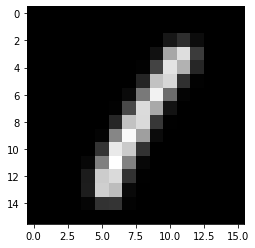

In [20]:
show_data(train_dataset[3])

In [33]:
class CNN(nn.Module):
    def __init__(self, out_1 = 16, out_2 = 32):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels = 1, out_channels = out_1, kernel_size = 5, padding = 2)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)
        self.cnn2 = nn.Conv2d(in_channels = out_1, out_channels = out_2, kernel_size = 5, stride = 1, padding = 2)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)
        self.fc1 = nn.Linear(out_2 * 4 * 4, 10)
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x
    def activations(self, x):
        z1 = self.cnn1(x)
        a1 = torch.relu(z1)
        out = self.maxpool1(a1)
        z2 = self.cnn2(out)
        a2 = torch.relu(z2)
        out1 = self.maxpool2(a2)
        out = out.view(out.size(0), -1)
        return z1, a1, z2, a2, out1, out

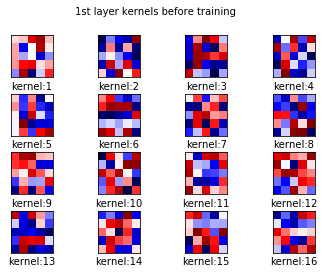

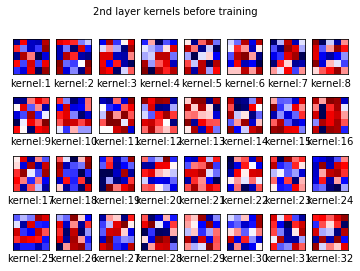

In [34]:
model = CNN(out_1 = 16, out_2 = 32)
plot_parameters(model.state_dict()['cnn1.weight'], number_rows=4, name="1st layer kernels before training ")
plot_parameters(model.state_dict()['cnn2.weight'], number_rows=4, name='2nd layer kernels before training' )

In [35]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = 100)
validation_loader = torch.utils.data.DataLoader(dataset = validation_dataset, batch_size = 5000)

In [36]:
epochs = 3
cost_list = []
accuracy_list = []
n_test = len(validation_dataset)
cost = 0

def train_model(epochs):
    for epoch in range(epochs):
        cost = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            cost += loss.data
        cost_list.append(cost)
        correct = 0
        for x_test, y_test in validation_loader:
            z = model(x_test)
            _, y_hat = torch.max(z.data, 1)
            correct += (y_hat == y_test).sum().item()
        accuracy = correct / n_test
        accuracy_list.append(accuracy)
train_model(epochs)

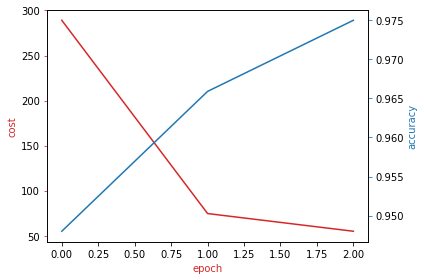

In [37]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list, color = color)
ax1.set_xlabel('epoch', color = color)
ax1.set_ylabel('cost', color = color)
ax1.tick_params(axis = 'y', color = color)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

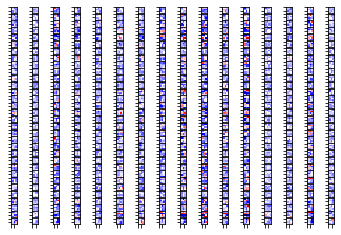

In [38]:
plot_channels(model.state_dict()['cnn1.weight'])
plot_channels(model.state_dict()['cnn2.weight'])

AttributeError: 'int' object has no attribute 'item'

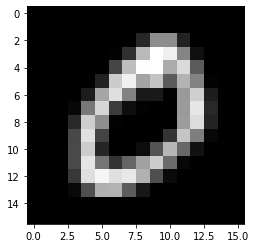

In [39]:
show_data(train_dataset[1])

In [41]:
out = model.activations(train_dataset[1][0].view(1, 1, IMAGE_SIZE, IMAGE_SIZE))

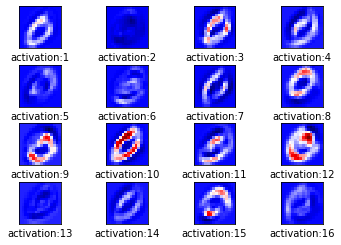

In [42]:
plot_activations(out[0], number_rows = 4, name = 'output after the 1st cnn')

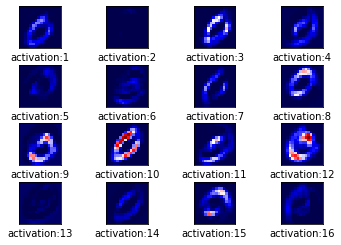

In [43]:
plot_activations(out[1], number_rows = 4, name = 'output after the 1st relu')

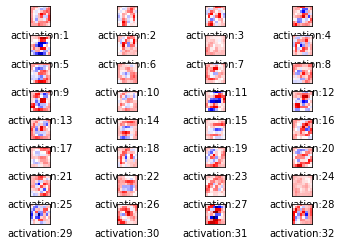

In [44]:
plot_activations(out[2], number_rows = 32 // 4, name = 'output after the 2nd cnn')

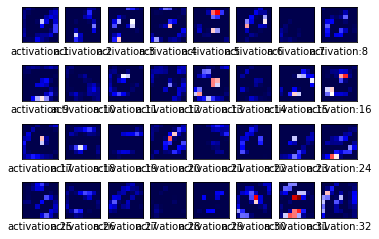

In [45]:
plot_activations(out[3], number_rows = 4, name = 'output after the 2nd relu')

AttributeError: 'int' object has no attribute 'item'

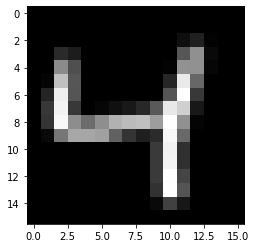

In [46]:
show_data(train_dataset[2])

In [48]:
out = model.activations(train_dataset[2][0].view(1, 1, IMAGE_SIZE, IMAGE_SIZE))

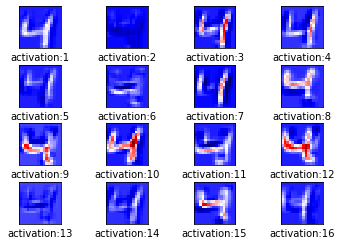

In [49]:
plot_activations(out[0], number_rows = 4, name = 'output after the 1st cnn')

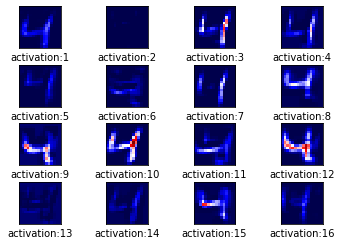

In [50]:
plot_activations(out[1], number_rows=4, name="Output after the 1st Relu")

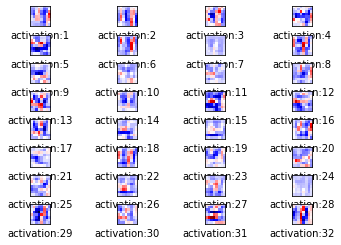

In [51]:
plot_activations(out[2], number_rows=32 // 4, name="Output after the 2nd CNN")

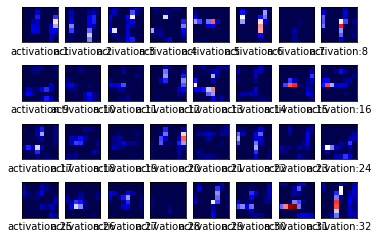

In [52]:
plot_activations(out[3], number_rows=4, name="Output after the 2nd Relu")

In [53]:
count = 0
for x, y in torch.utils.data.DataLoader(dataset = validation_dataset, batch_size = 1):
    z = model(x)
    _, y_hat = torch.max(z, 1)
    if y_hat != y:
        show_data((x, y))
        plt.show()
        print()

SyntaxError: unexpected EOF while parsing (<ipython-input-53-0431d19ad3f5>, line 2)